# Introduction to bioinformatics - project no. 2
## CpG islands and DNA Methylation analysis

## Necessary libraries

In [1]:
import pandas as pd
import copy
import time

## Data load

In [7]:
cpg_islands = pd.read_csv("data/cpgIslandExt.txt", sep='\t', header=None)
dna_methylation = pd.read_csv("data/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed", sep='\t', header=None)
chromosomes_sizes = pd.read_csv("data/hg19.chrom.sizes.txt", sep='\t', header=None)

In [8]:
dna_methylation.head()

,0,1,2,3,4,5,6,7,8
0,chr16,53468112,53468162,cg00000029,486,+,53468112,53468162,"128,0,128"
1,chr3,37459206,37459256,cg00000108,916,+,37459206,37459256,"255,127,0"
2,chr3,171916037,171916087,cg00000109,815,+,171916037,171916087,"255,127,0"
3,chr1,91194674,91194724,cg00000165,806,-,91194674,91194724,"255,127,0"
4,chr8,42263294,42263344,cg00000236,843,-,42263294,42263344,"255,127,0"


## Data preprocessing

In [9]:
dna_methylation = dna_methylation.loc[:,0:2]
dna_methylation.columns = ["chr_nr", "start", "stop"]
dna_methylation['location'] = ((dna_methylation['stop']-dna_methylation['start'])/2 +
                            dna_methylation['start']).astype('int32')

chromosomes_sizes.columns = ['chr_nr', 'size']
chromosomes_sizes.set_index('chr_nr', inplace=True)

cpg_islands = cpg_islands.loc[:, 1:3]
cpg_islands.columns = ['chr_nr', 'start', 'stop']

## Part 2

In [10]:
chromosomes_indexes = [('chr' + str(i)) for i in range(1, 23)]
chromosomes = [cpg_islands[cpg_islands.chr_nr == i].sort_values('start').reset_index() for i in chromosomes_indexes]

In [11]:
def one_type_border(curr_end_A, curr_start_B, leap_length):
    """
    return: end of one segment, start of another segment
    """
    if curr_end_A + leap_length < curr_start_B - leap_length:
        return curr_end_A + leap_length, curr_start_B - leap_length
    else:
        return None

In [35]:
islands = pd.DataFrame(columns = ['chr_nr', 'start', 'stop'])
shores = pd.DataFrame(columns = ['chr_nr', 'start', 'stop'])
shelves = pd.DataFrame(columns = ['chr_nr', 'start', 'stop'])
seas = pd.DataFrame(columns = ['chr_nr', 'start', 'stop'])
df_list = [islands, shores, shelves, seas]
nrow = [0] * len(df_list)
leap_length_start = [0, 2000, 4000, 4000]
leap_length = [0, 2000, 2000, 1000000]

#print(time.asctime(time.localtime(time.time())))
for k, chromosome in enumerate(chromosomes):
    
    n = chromosome.shape[0]
    print(f"chr_nr={k}")
    for j in range(n):
        """
        j - j-ta wyspa na k-tym chromosomie
        n - liczba wysp
        """
        # ------------------------------------------
        # Przypadek pierwszej wyspy. Co się dzieje przed nią.
        if j == 0:
            curr_start_B = chromosome['start'][j]
            for i, el in enumerate(df_list):
                step = curr_start_B - leap_length[i]
                if step <= 0:
                    el.loc[nrow[i]] = (chromosomes_indexes[k], 0, curr_start_B)
                    nrow[i] += 1
                    break
                else:
                    el.loc[nrow[i]] = (chromosomes_indexes[k], step, curr_start_B)
                    nrow[i] += 1
                    curr_start_B = step
        # ------------------------------------------
        # Przypadek ostatniej wyspy. Co się dzieje za nią.
        elif j == n:
            curr_end_A = chromosome['stop'][j]
            for i, el in enumerate(df_list):
                step = curr_end_A + leap_length[i]
                if step >= chromosomes_sizes['size'][k]:
                    el.loc[nrow[i]] = (chromosomes_indexes[k], curr_end_A, chromosomes_sizes['size'][k])
                    break
                else:
                    el.loc[nrow[i]] = (chromosomes_indexes[k], curr_end_A, step)
                    curr_end_A = step
        # -----------------------------------------
        # Wszystkie pozostałe wyspy wewnątrz. Co się dzieje pomiędzy nimi.
        else:
            curr_end_A = chromosome['stop'][j-1]
            curr_start_B = chromosome['start'][j]

            for i, el in enumerate(df_list):
                result = one_type_border(curr_end_A, curr_start_B, leap_length[i])

                if result is None:
                    # zajmujemy całą przestrzeń pomiędzy zakresami, bo się zazębiają. 
                    el.loc[nrow[i]] = (chromosomes_indexes[k], curr_end_A, curr_start_B)
                    nrow[i] += 1
                    # przerywamy bo nie ma już miejsca na inne elementy pomiędzy wyspami
                    break
                else:
                    el.loc[nrow[i]] = (chromosomes_indexes[k], curr_end_A, result[0])
                    nrow[i] += 1
                    
                    el.loc[nrow[i]] = (chromosomes_indexes[k],result[1], curr_start_B)
                    nrow[i] += 1
                    
                    curr_end_A = result[0]
                    curr_start_B = result[1]

#print(time.asctime(time.localtime(time.time())))

chr_nr=0


In [ ]:
for i in df_list:
    print(len(i))

In [29]:
# cpg_islands.to_csv('islands_v2.csv')
# df_list[1].to_csv('shores_v2.csv')
# df_list[2].to_csv('shelves_v2.csv')
# df_list[3].to_csv('seas_v2.csv')

In [12]:
islands = pd.read_csv('islands_v2.csv')
shores = pd.read_csv('shores_v2.csv')
shelves = pd.read_csv('shelves_v2.csv')
seas = pd.read_csv('seas_v2.csv')

In [13]:
dna_methylation.head()

,chr_nr,start,stop,location
0,chr16,53468112,53468162,53468137
1,chr3,37459206,37459256,37459231
2,chr3,171916037,171916087,171916062
3,chr1,91194674,91194724,91194699
4,chr8,42263294,42263344,42263319


In [14]:
methylations_by_chr = []

for i in chromosomes_indexes:
    methylations_by_chr.append(dna_methylation[dna_methylation.chr_nr == i])

In [15]:
from tqdm import tqdm

In [16]:
methylations_by_chr[0].shape

(46567, 4)

In [28]:
islands_count = 0
shores_count = 0
shelves_count = 0
seas_count = 0
count_list = [islands_count, shores_count, shelves_count, seas_count]

for i, el in enumerate(methylations_by_chr):
    seas_met = seas[seas.chr_nr == chromosomes_indexes[i]]
    shelves_met = shelves[shelves.chr_nr == chromosomes_indexes[i]]
    islands_met = islands[islands.chr_nr == chromosomes_indexes[i]]
    shores_met = shores[shores.chr_nr == chromosomes_indexes[i]]
    met_list = [islands_met, shores_met, shelves_met, seas_met]
    
    
    for j, met in tqdm(el.iterrows()):
        for k, df in enumerate(met_list):
            met_query = df[df.start <= met.location].sort_values('stop')
            if met_query.shape[0] >= 1 and met_query.iloc[met_query.shape[0] - 1].stop >= met.location:
                count_list[k] += 1
                break

46567it [04:33, 170.24it/s]
34501it [03:11, 180.20it/s]
24996it [02:12, 188.08it/s]
20276it [01:48, 186.91it/s]
24168it [02:07, 189.54it/s]
36438it [03:24, 178.56it/s]
29844it [02:41, 185.35it/s]
20787it [01:56, 178.32it/s]
9736it [00:42, 231.74it/s]
24212it [01:54, 211.20it/s]
28654it [02:11, 218.60it/s]
24385it [01:54, 212.20it/s]
12175it [00:56, 216.21it/s]
14987it [01:12, 208.14it/s]
15146it [01:11, 210.91it/s]
21876it [01:44, 209.09it/s]
27775it [02:11, 211.31it/s]
5889it [00:22, 265.80it/s]
25449it [01:43, 244.99it/s]
10302it [00:39, 263.61it/s]
4205it [00:16, 252.41it/s]
8502it [00:33, 252.37it/s]


In [29]:
import seaborn as sns

In [30]:
plot_data = pd.DataFrame({
    'count_type': ['islands', 'shores', 'shelves', 'seas'],
    'count': count_list
})
plot_data.to_csv('results_v2.csv')
plot_data

,count_type,count
0,islands,132325
1,shores,122665
2,shelves,45432
3,seas,169364


In [53]:
sns.set(style="whitegrid")

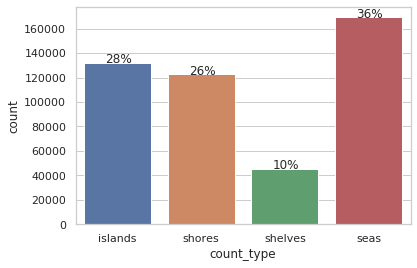

In [52]:
ax = sns.barplot(data=plot_data, x='count_type', y='count')
for p in ax.patches:
    ax.annotate('{:.0f}%'.format(100*p.get_height()/plot_data['count'].sum()), (p.get_x()+ 0.25, p.get_height()+0.2))

In [2]:
islands = pd.read_csv('islands_v2.csv')
shores = pd.read_csv('shores_v2.csv')
shelves = pd.read_csv('shelves_v2.csv')
seas = pd.read_csv('seas_v2.csv')

In [16]:
islands.iloc[:, 1:4].to_csv('islands_v3.bed', sep='\t', index=False)
shores.iloc[:, 1:4].to_csv('shores_v3.bed', sep='\t', index=False)
shelves.iloc[:, 1:4].to_csv('shelves_v3.bed', sep='\t', index=False)
seas.iloc[:, 1:4].to_csv('seas_v3.bed', sep='\t', index=False)